# 通し課題 Day2
## 目的
 課題①　KickStarter Project　
 https://www.kaggle.com/kemical/kickstarter-projects
 
 について分類アルゴリズムを実装評価する。
 
　DAY１で発生していた状況は以下の通り
- logistic回帰の精度が悪い 50%程度しかない

 
 DAY2で学んだ以下の項目についてkickstarterでも実施する
- 各データについて標準化を行う
- 訓練誤差/汎化誤差をLogistic回帰でもう一度解いてみて確認する
- SVMのお試し


 

## 前準備
DAY1と同様にデータの読込＋加工を行う

In [1]:
#各種必要ライブラリのロード
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from common_func import plot_decision_regions

In [2]:
#データの読込
df = pd.read_csv("./ks-projects-201801.csv")

In [3]:
#開始時にはわからないデータを除去する
df = df.drop('pledged', axis=1)
df = df.drop('backers', axis=1)
df = df.drop('usd pledged', axis=1)
df = df.drop('usd_pledged_real', axis=1)

In [4]:
#stateについてsuccesful及びfailed以外のデータを除去する
df_success = df[df['state'] == 'successful']
df_failed = df[df['state'] == 'failed']

df_input = pd.concat([df_success, df_failed])

for index, value in df_input['state'].value_counts().iteritems():
    print(index, ': ', value)

failed :  197719
successful :  133956


次にカテゴリ変数のdummy変数化を行う。

In [5]:
df_input = pd.concat([df_input, pd.get_dummies(df_input['main_category'])], axis=1)
df_input = pd.concat([df_input, pd.get_dummies(df_input['currency'])], axis=1)
df_input = pd.concat([df_input, pd.get_dummies(df_input['country'])], axis=1)
df_input.tail()

,ID,name,category,main_category,currency,deadline,goal,launched,state,country,...,JP,LU,MX,"N,0""",NL,NO,NZ,SE,SG,US
378654,999975836,"Homemade fresh dog food, Cleveland OH",Small Batch,Food,USD,2017-04-19,6500.0,2017-03-20 22:08:22,failed,US,...,0,0,0,0,0,0,0,0,0,1
378657,999977640,The Tribe,Narrative Film,Film & Video,USD,2011-07-19,1500.0,2011-06-22 03:35:14,failed,US,...,0,0,0,0,0,0,0,0,0,1
378658,999986353,Walls of Remedy- New lesbian Romantic Comedy f...,Narrative Film,Film & Video,USD,2010-08-16,15000.0,2010-07-01 19:40:30,failed,US,...,0,0,0,0,0,0,0,0,0,1
378659,999987933,BioDefense Education Kit,Technology,Technology,USD,2016-02-13,15000.0,2016-01-13 18:13:53,failed,US,...,0,0,0,0,0,0,0,0,0,1
378660,999988282,Nou Renmen Ayiti! We Love Haiti!,Performance Art,Art,USD,2011-08-16,2000.0,2011-07-19 09:07:47,failed,US,...,0,0,0,0,0,0,0,0,0,1


 ### DAY1で発生していた状況の原因確認
 - 仮説：パラメータの標準化ができていないため、極端なrangeを持つデータに引っ張られた？

In [6]:
y = df_input["state"] == 'successful'
inp = df_input.drop(['state','ID', 'name','category','deadline','launched', 'main_category', 'currency', 'country'], axis=1)
X = inp.values
clf = SGDClassifier(loss='log', penalty='none', max_iter=1000, fit_intercept=True, random_state=1234)
clf.fit(X, y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='none', power_t=0.5, random_state=1234,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [7]:
y_est = clf.predict(X)

In [8]:
# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))

対数尤度 = -17.018
正答率 = 50.729%


In [9]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['正解 = successful', '正解 = failed'], 
                        columns=['予測 = successful', '予測 = failed'])
conf_mat

,予測 = successful,予測 = failed
正解 = successful,46368,151351
正解 = failed,12070,121886


In [10]:
# 係数を棒グラフで表示
abs_coef = abs(clf.coef_)
#plt.barh(np.arange(0, len(clf.coef_)), abs_coef, tick_label=inp.columns.values)
#plt.show()
abs_coef

array([[1.10517369e-01, 3.26444512e+00, 2.68701018e+03, 1.59767171e+03,
        2.53490111e+02, 6.50068979e+02, 2.66192850e+03, 1.01341110e+03,
        5.78666124e+03, 1.19999538e+03, 3.23476447e+03, 1.35316354e+02,
        6.44939986e+03, 6.79251379e+02, 2.51417870e+03, 1.16076244e+03,
        1.83680369e+03, 4.52701146e+02, 9.61884874e+02, 3.60328508e+01,
        9.26653824e+01, 6.01488218e+02, 2.25893942e+03, 3.83056715e+01,
        1.85835869e+00, 7.00553484e+01, 3.77455741e+01, 9.76160728e+01,
        9.78593744e+01, 3.59432069e+01, 2.70776186e+04, 1.36562166e+01,
        4.52566376e+02, 2.13702186e+01, 9.60543866e+02, 3.60328508e+01,
        1.41861553e+02, 9.09164549e+01, 6.18078908e+01, 1.97073750e+02,
        2.25431701e+03, 3.83056715e+01, 3.47658094e+01, 4.46054791e+01,
        1.85835869e+00, 5.24006322e+00, 7.00553484e+01, 3.23752467e+01,
        8.11011882e+01, 3.75821101e+01, 9.76160728e+01, 9.79187102e+01,
        3.59432069e+01, 2.70532006e+04]])

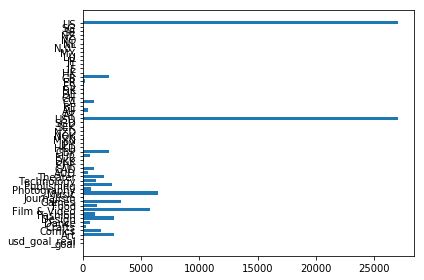

In [11]:
plt.barh(np.arange(0, len(clf.coef_[0])), abs_coef[0], tick_label=inp.columns.values)
plt.tight_layout()
plt.show()

- 極端な重みが付いている変数がある
- 変数を標準化する必要がある

### 学習用データと評価用データに分割する
- 以後正しく汎化性能を測るため、データを訓練用と評価用に分割する。
- データ数が多いため一旦はホールドアウト法で実装してみる


In [13]:
test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）

In [14]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(265340, 54)
(265340,)
(66335, 54)
(66335,)


In [15]:
clf = SGDClassifier(loss='log', penalty='none', max_iter=1000, fit_intercept=True, random_state=1234)
clf.fit(X_train, y_train)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='none', power_t=0.5, random_state=1234,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [16]:
y_est = clf.predict(X_test)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_est)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_est)))

対数尤度 = -15.175
正答率 = 56.065%


In [17]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est), 
                        index=['正解 = successful', '正解 = failed'], 
                        columns=['予測 = successful', '予測 = failed'])
conf_mat

,予測 = successful,予測 = failed
正解 = successful,16966,22771
正解 = failed,6373,20225


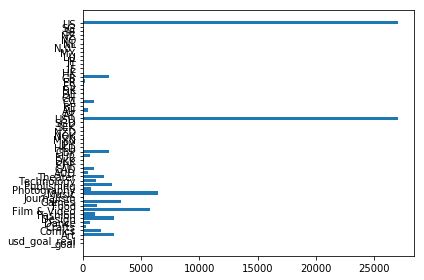

In [18]:
plt.barh(np.arange(0, len(clf.coef_[0])), abs_coef[0], tick_label=inp.columns.values)
plt.tight_layout()
plt.show()

### 標準化の実行
- 一部の係数が異常に大きいため、判定がうまく行っていない可能性がある
- 標準化を行い係数の重みを均一にしてみる

In [ ]:
# 標準化
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)

In [ ]:
X_test_std = stdsc.transform(X_test)

In [10]:
clf = SGDClassifier(loss='log', penalty='none', max_iter=1000, fit_intercept=True, random_state=1234)
clf.fit(X_train_std, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='none', power_t=0.5, random_state=1234,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [11]:
y_est = clf.predict(X_test_std)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_est)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_est)))

対数尤度 = -12.604
正答率 = 63.508%


In [12]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est), 
                        index=['正解 = successful', '正解 = failed'], 
                        columns=['予測 = successful', '予測 = failed'])
conf_mat

,予測 = successful,予測 = failed
正解 = successful,33308,6429
正解 = failed,17778,8820


- 精度は50% →　63％まで改善した
- 他の条件は一緒のため、標準化の効果だと思われる

### SVMの実装
- SVMを実装し精度を確認する
- GridSearchでハイパーパラメータのチューニングを行う
- KickStarterでSVMを実行した場合、時間がかかりすぎるため、20%程度に削減したデータで検証してみる
- もっとも良い性能がでるハイパーパラメータで全量を学習してみて精度を確認する


In [1]:
#必要なライブラリのインポート
#各種必要ライブラリのロード
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from common_func import plot_decision_regions
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [2]:
#データの読込
df = pd.read_csv("./ks-projects-201801.csv")
#開始時にはわからないデータを除去する
df = df.drop('pledged', axis=1)
df = df.drop('backers', axis=1)
df = df.drop('usd pledged', axis=1)
df = df.drop('usd_pledged_real', axis=1)
#stateについてsuccesful及びfailed以外のデータを除去する
df_success = df[df['state'] == 'successful']
df_failed = df[df['state'] == 'failed']

df_input = pd.concat([df_success, df_failed])
    
df_input = pd.concat([df_input, pd.get_dummies(df_input['main_category'])], axis=1)
df_input = pd.concat([df_input, pd.get_dummies(df_input['currency'])], axis=1)
df_input = pd.concat([df_input, pd.get_dummies(df_input['country'])], axis=1)

y = df_input["state"] == 'successful'
inp = df_input.drop(['state','ID', 'name','category','deadline','launched', 'main_category', 'currency', 'country'], axis=1)
X = inp.values

In [3]:
#学習用データと検証用データ
test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）

In [4]:
# 標準化
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [5]:
test_size = 0.015        # 全データを学習させるのは難しいため、1％程度のデータを抽出する
_, X_train_std_sample, _, y_train_std_sample = train_test_split(X_train_std, y_train, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）

In [6]:
print(X_train_std_sample.shape)
print(y_train_std_sample.shape)

(3981, 54)
(3981,)


In [7]:
# SVMの実行
C = 5
svm_clf = SVC(C=C, kernel="linear", cache_size=2000)
svm_clf.fit(X_train_std_sample, y_train_std_sample)

SVC(C=5, cache_size=2000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [8]:
y_est = svm_clf.predict(X_test_std)

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_est)))

正答率 = 62.009%


In [9]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est), 
                        index=['正解 = successful', '正解 = failed'], 
                        columns=['予測 = successful', '予測 = failed'])
conf_mat

,予測 = successful,予測 = failed
正解 = successful,33394,6343
正解 = failed,18858,7740


- 1%程度の学習データしか使っていないが汎化性能がlogistic回帰と同等になった
- ハイパーパラメータを変更し精度がどの程度変わるかを確認する

In [14]:
%%time
parameters = {'kernel':['rbf'], 'C':[0.5,1,2], 'gamma':[0.1,0.3,0.5]} # ここを編集する
model = SVC()
clf = GridSearchCV(model, parameters, cv=3,)
clf.fit(X_train_std_sample, y_train_std_sample)
print(clf.best_params_, clf.best_score_)

{'C': 0.5, 'gamma': 0.5, 'kernel': 'rbf'} 0.608641044963577
CPU times: user 27 s, sys: 121 ms, total: 27.1 s
Wall time: 27.3 s


In [15]:
%%time
parameters = {'kernel':['rbf'], 'C':[0.1,0.25,0.5], 'gamma':[0.5,0.6,0.7]} # ここを編集する
model = SVC()
clf = GridSearchCV(model, parameters, cv=3,)
clf.fit(X_train_std_sample, y_train_std_sample)
print(clf.best_params_, clf.best_score_)

{'C': 0.25, 'gamma': 0.5, 'kernel': 'rbf'} 0.6106505903039438
CPU times: user 27.3 s, sys: 116 ms, total: 27.4 s
Wall time: 27.6 s


In [16]:
%%time
parameters = {'kernel':['rbf'], 'C':[0.2,0.25,0.3], 'gamma':[0.5,0.6]} # ここを編集する
model = SVC()
clf = GridSearchCV(model, parameters, cv=3,)
clf.fit(X_train_std_sample, y_train_std_sample)
print(clf.best_params_, clf.best_score_)

{'C': 0.2, 'gamma': 0.5, 'kernel': 'rbf'} 0.6121577493092187
CPU times: user 20.1 s, sys: 125 ms, total: 20.3 s
Wall time: 20.5 s


In [17]:
# 最適パラメータを用いて識別する
clf2 = SVC(**clf.best_params_)
clf2.fit(X_train_std_sample, y_train_std_sample)
print("識別精度=",clf2.score(X_test, y_test))

識別精度= 0.5990352001206


- グリッドサーチでハイパーパラメータ探索を行なったが精度は改善しなかった
- 学習に用いたデータ数が少なすぎる？

- もう少し、データを増やせないか確認する
- カテゴリ変数が多く次元が大きくなってしまっている。特徴量削減の効果を試してみる（特に計算量が減ることを期待したい）